## Import libraries

In [1]:
from sklearn.model_selection import train_test_split
from CCD_implementation import logisitic_regression
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import roc_auc_score, average_precision_score, balanced_accuracy_score, f1_score
import numpy as np
import pandas as pd
import openml
from generating_dataset import generate_dataset
from preprocessing import split, check_feature_sample_ratio, delete_corr_columns, fill_na, assign_target_column, add_permuted_columns,  drop_categorical

## Synthetic dataset experimnets

In [2]:
n_values = [100, 200, 300, 400, 500] 
p_values = [0.4, 0.5, 0.6, 0.7]
d_values = [10, 20, 50, 100]
g_values = [0.1, 0.25, 0.5, 0.75, 1.0]
# n_values = [100, 500, 1000] 
# p_values = [0.5]  # Fix p = 0.5
# d_values = [10, 50, 100]
# g_values = [0.1, 0.5, 1.0]

results = []

for n in n_values:
    for p in p_values:
        for d in d_values:
            for g in g_values:
                X, y = generate_dataset(p, n, d, g)
                X_train, X_test = X[:int(0.8*n)],  X[int(0.8*n):]
                y_train, y_test = y[:int(0.8*n)],  y[int(0.8*n):]

                log_reg_ccd = logisitic_regression()
                log_reg_sklearn = LogisticRegression(penalty=None)
                log_reg_ccd.fit(X_train, y_train, max_iter=100, weights=True, fit_intercept=True)

                log_reg_sklearn.fit(X_train, y_train)

                y_proba_ccd = log_reg_ccd.predict_proba(X_test)
                y_proba_sklearn = log_reg_sklearn.predict_proba(X_test)[:, 1]

                y_pred_ccd = log_reg_ccd.predict(X_test)
                y_pred_sklearn = log_reg_sklearn.predict(X_test)

                roc_auc_ccd = roc_auc_score(y_test, y_proba_ccd)
                balanced_accuracy_ccd = balanced_accuracy_score(y_test, y_pred_ccd)

                roc_auc_sklearn = roc_auc_score(y_test, y_proba_sklearn)
                balanced_accuracy_sklearn = balanced_accuracy_score(y_test, y_pred_sklearn)

                results.append({
                    'n': n,
                    'p': p,
                    'd': d,
                    'g': g,
                    'roc_auc_ccd': roc_auc_ccd,
                    'roc_auc_sklearn': roc_auc_sklearn,
                    'balanced_accuracy_ccd': balanced_accuracy_ccd,
                    'balanced_accuracy_sklearn': balanced_accuracy_sklearn
                })
            
results_df = pd.DataFrame(results)

In [10]:
def plot_comparison(parameter, metric, df):
    plt.figure(figsize=(12, 6))
    
    plt.plot(df[parameter], df[f'{metric}_ccd'], label='LogRegCCD', color='blue', marker='o')
    plt.plot(df[parameter], df[f'{metric}_sklearn'], label='LogisticRegression (sklearn)', color='red', marker='x')
    
    plt.title(f'{metric} Comparison - {parameter}')
    plt.xlabel(parameter)
    plt.ylabel(f'{metric}')
    plt.legend()
    plt.show()

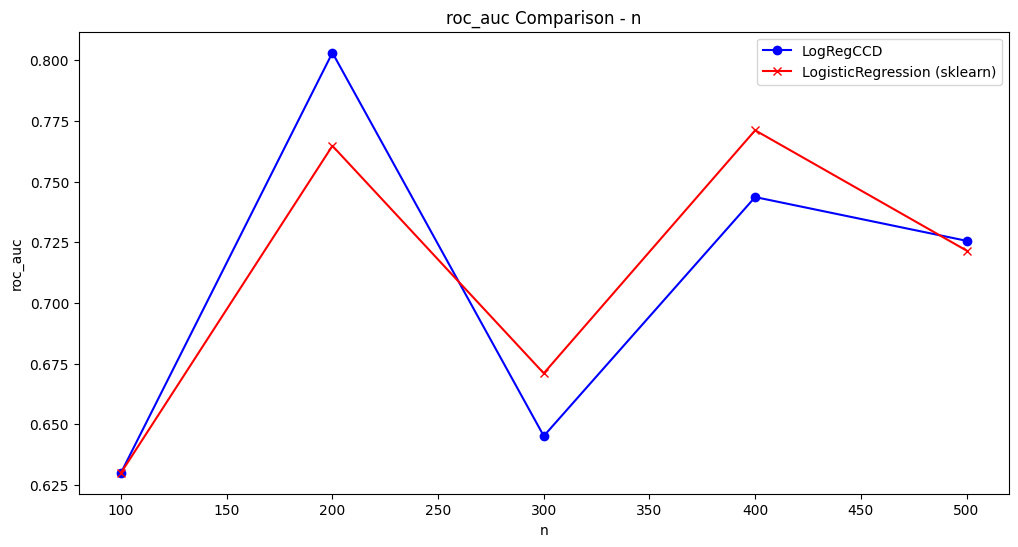

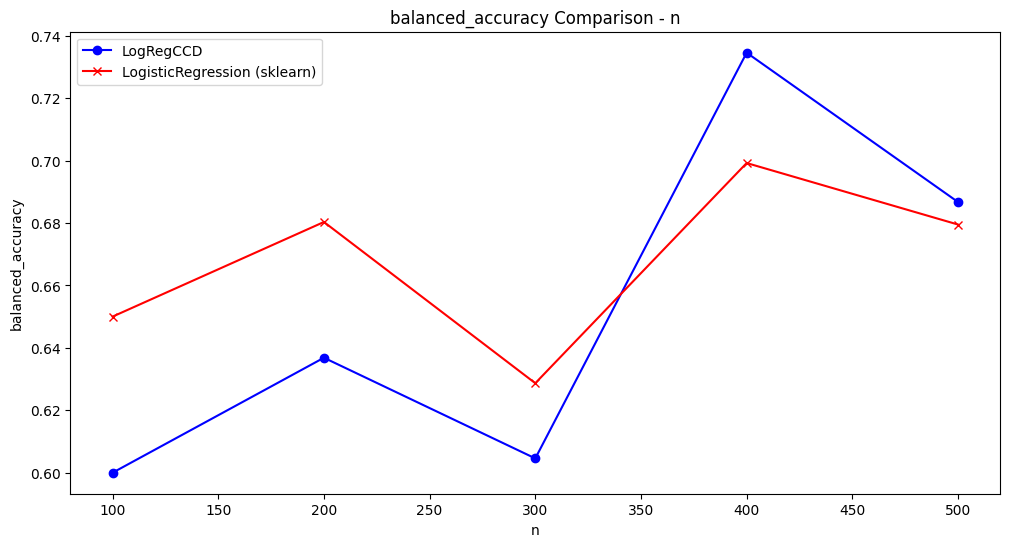

In [11]:
df=results_df[(results_df["p"]==0.5) & (results_df["d"]==10) & (results_df["g"]==0.5)]
plot_comparison('n', 'roc_auc', df) 
plot_comparison('n', 'balanced_accuracy', df) 

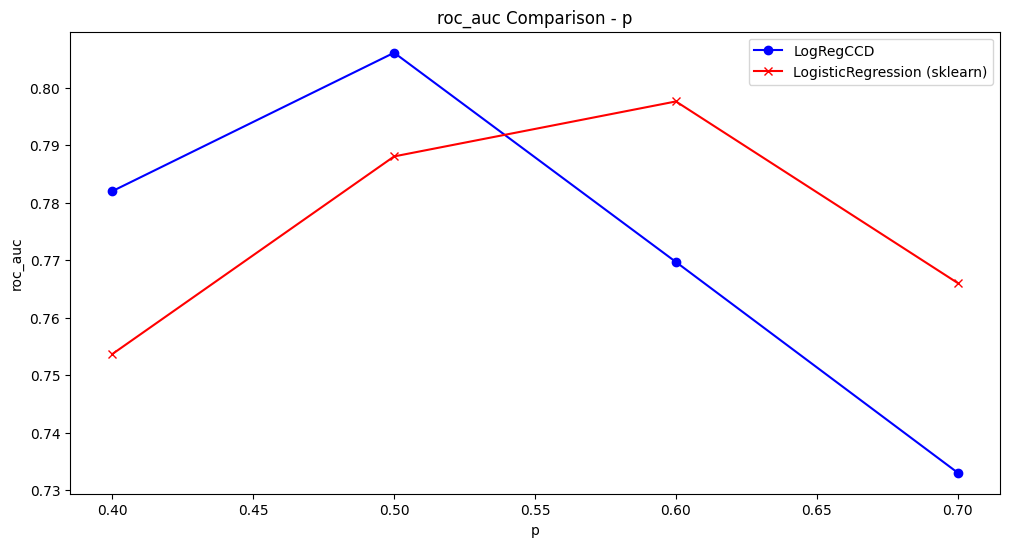

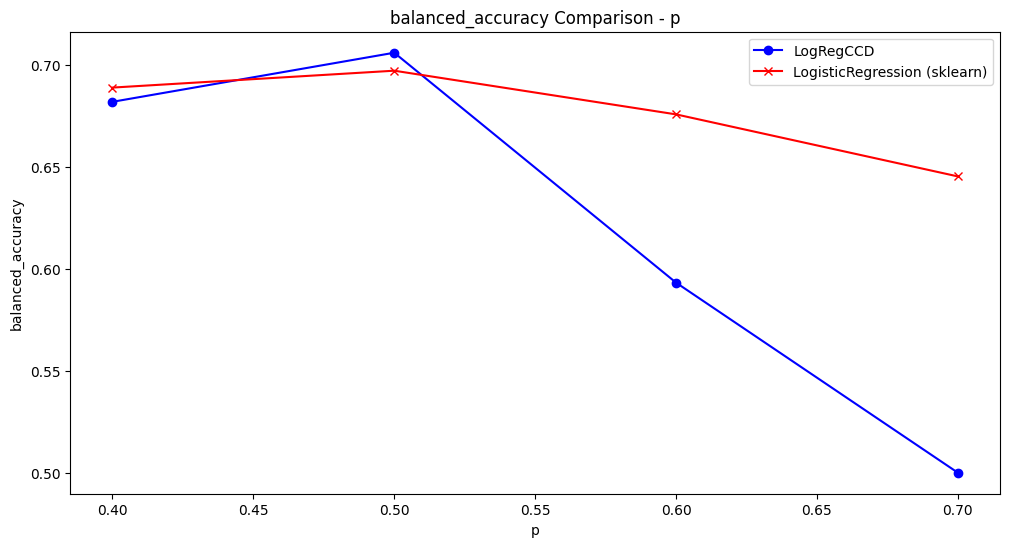

In [12]:
df=results_df[(results_df["n"]==500) & (results_df["d"]==20) & (results_df["g"]==0.1)]
plot_comparison('p', 'roc_auc', df) 
plot_comparison('p', 'balanced_accuracy', df) 

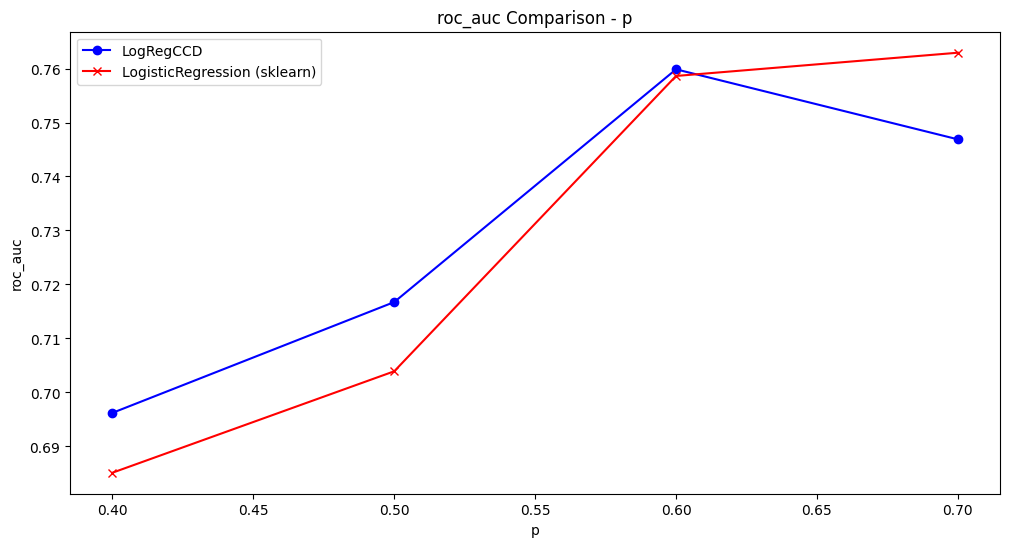

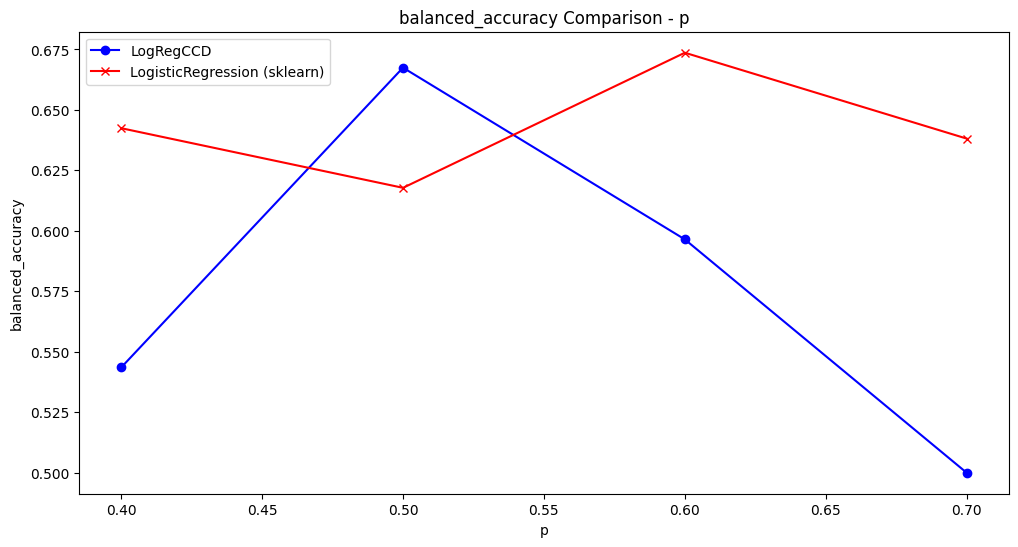

In [13]:
df=results_df[(results_df["n"]==500) & (results_df["d"]==20) & (results_df["g"]==0.5)]
plot_comparison('p', 'roc_auc', df) 
plot_comparison('p', 'balanced_accuracy', df) 

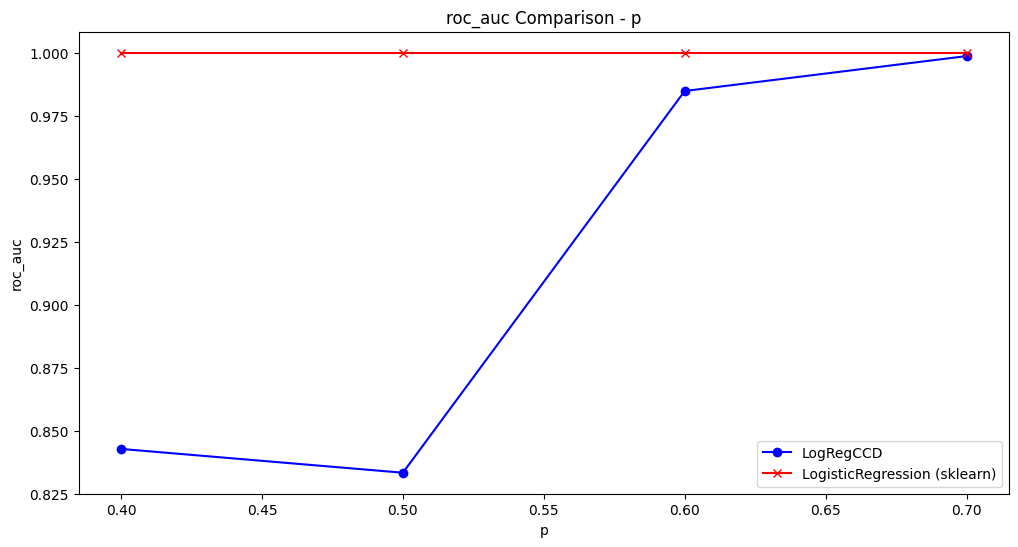

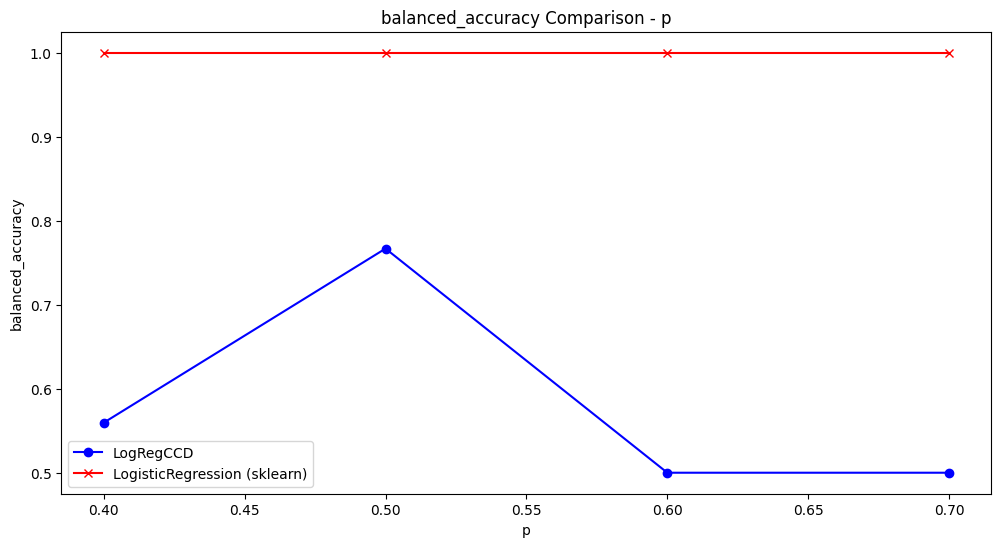

In [14]:
df=results_df[(results_df["n"]==500) & (results_df["d"]==20) & (results_df["g"]==1)]
plot_comparison('p', 'roc_auc', df) 
plot_comparison('p', 'balanced_accuracy', df) 

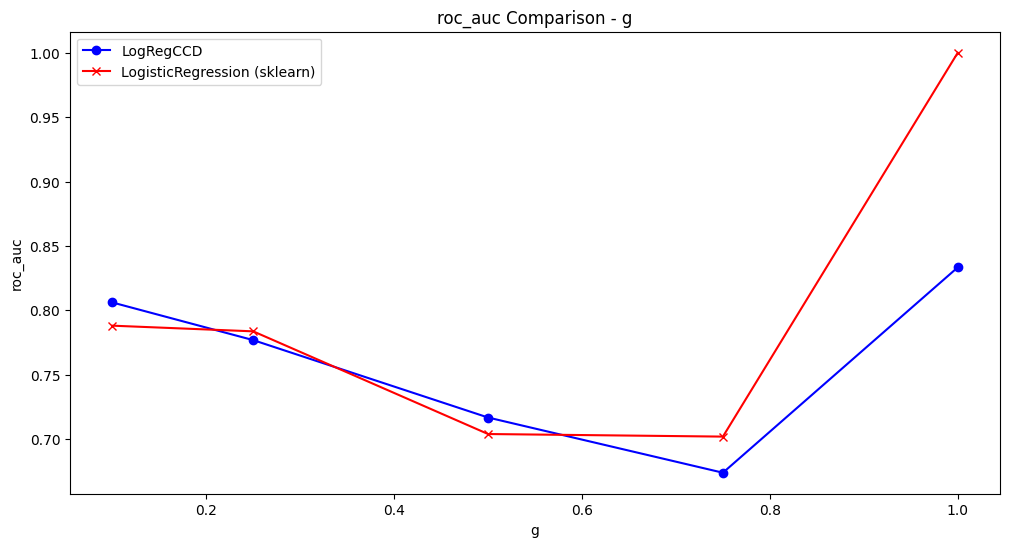

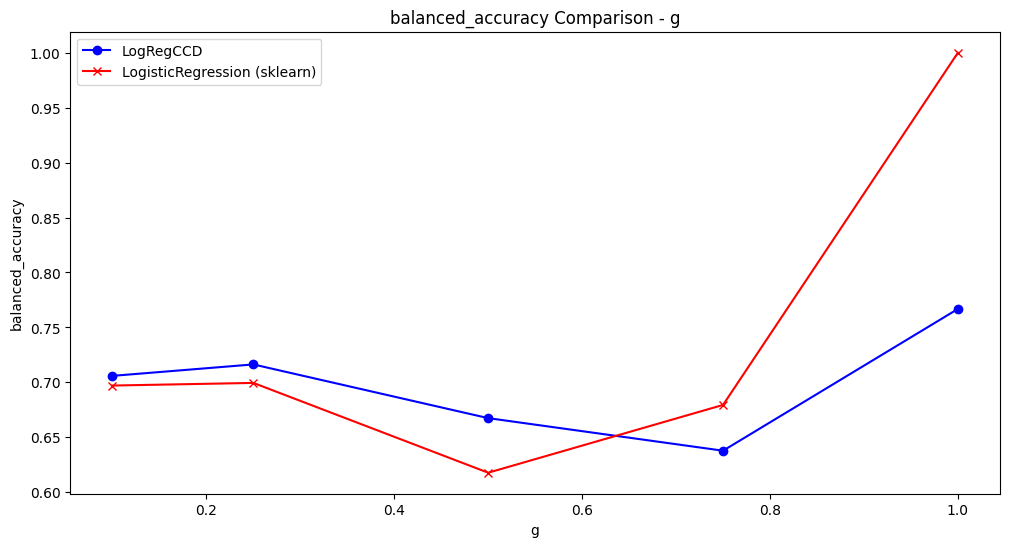

In [15]:
df=results_df[(results_df["n"]==500) & (results_df["p"]==0.5) & (results_df["d"]==20)]
plot_comparison('g', 'roc_auc', df) 
plot_comparison('g', 'balanced_accuracy', df) 

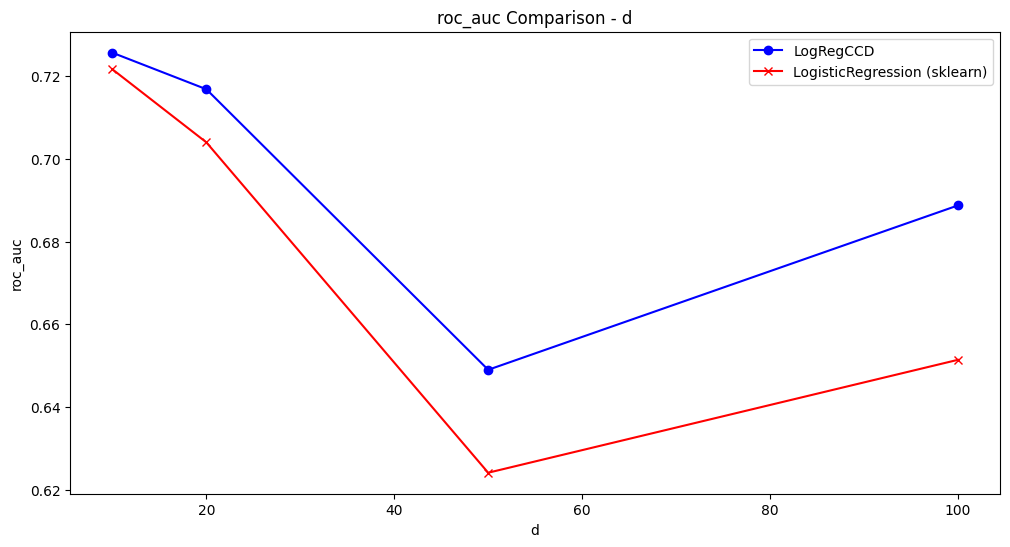

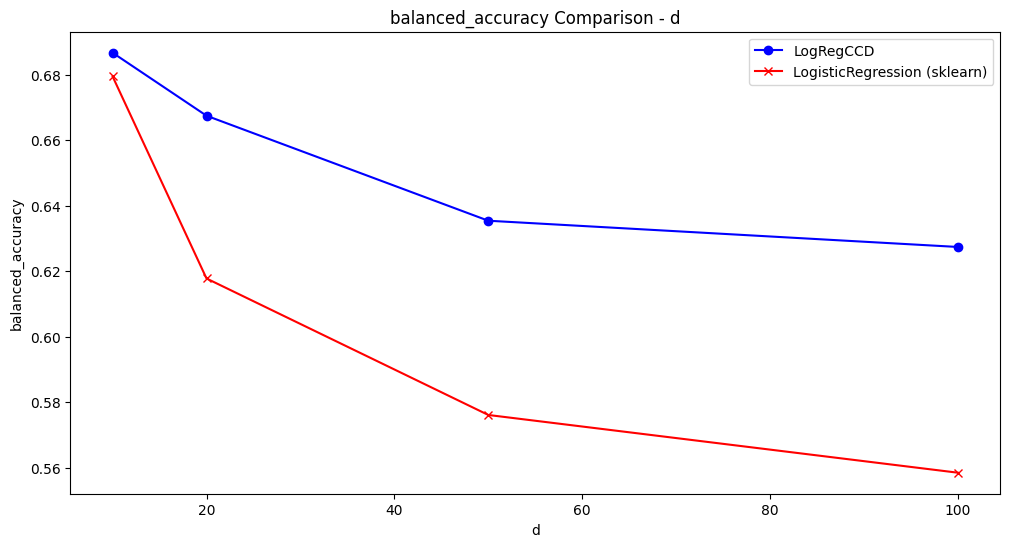

In [16]:
df=results_df[(results_df["n"]==500) & (results_df["p"]==0.5) & (results_df["g"]==0.5)]
plot_comparison('d', 'roc_auc', df) 
plot_comparison('d', 'balanced_accuracy', df) 

## Real datasets experiments

#### Arrythmia

In [2]:
col_names = [f"attr{i}" for i in range(1, 280)]
df_arythmia = pd.read_csv("./data/arrhythmia/arrhythmia.data", header=None, names=col_names, na_values="?")
print(df_arythmia.head())
df_arythmia = df_arythmia.reset_index()
df_arythmia.columns = df_arythmia.columns.astype(str)

    attr1  attr2  attr3  attr4  attr5  attr6  attr7  attr8  attr9  attr10  \
75      0    190     80     91    193    371    174    121    -16    13.0   
56      1    165     64     81    174    401    149     39     25    37.0   
54      0    172     95    138    163    386    185    102     96    34.0   
55      0    175     94    100    202    380    179    143     28    11.0   
75      0    190     80     88    181    360    177    103    -16    13.0   

    ...  attr270  attr271  attr272  attr273  attr274  attr275  attr276  \
75  ...      0.0      9.0     -0.9      0.0      0.0      0.9      2.9   
56  ...      0.0      8.5      0.0      0.0      0.0      0.2      2.1   
54  ...      0.0      9.5     -2.4      0.0      0.0      0.3      3.4   
55  ...      0.0     12.2     -2.2      0.0      0.0      0.4      2.6   
75  ...      0.0     13.1     -3.6      0.0      0.0     -0.1      3.9   

    attr277  attr278  attr279  
75     23.3     49.4        8  
56     20.4     38.8        

In [3]:
assign_target_column(df_arythmia, "attr279", [i for i in range(2,16)])
fill_na(df_arythmia)
delete_corr_columns(df_arythmia)
check_feature_sample_ratio(df_arythmia)

Unique values of label column [ 8  6 10  1  7 14  3 16  2  4  5  9 15]
target
0    267
1    185
Name: count, dtype: int64
attr10 8 null values
attr11 22 null values
attr12 1 null values
attr13 376 null values
attr14 1 null values
deleted features: ['attr160', 'attr163', 'attr170', 'attr184', 'attr192', 'attr193', 'attr194', 'attr203', 'attr207', 'attr211', 'attr214', 'attr217', 'attr224', 'attr234', 'attr243', 'attr254', 'attr263', 'attr273']
Shape after deletion (452, 262)
The number of features is enough: True, number of features: 262


In [22]:
X, y, X_train,X_valid, X_test, y_train, y_valid, y_test = split(df_arythmia)

In [25]:
def evaluate_lr_ccd(X_train, y_train, X_test, y_test, X_valid, y_valid, max_iter=100, a=1, measure=None, user_lambda=None, should_plot=True):
    model=logisitic_regression()
    model.fit(X_train, y_train, max_iter=max_iter, a=a, weights=None, user_lambda=user_lambda, fit_intercept=True, X_valid=X_valid, y_valid=y_valid, measure=measure)
    if should_plot:
        best_lambda=model.plot(X_valid, y_valid, measure='balanced accuracy')
        print(best_lambda)
    y_proba = model.predict_proba(X_test)
    #y_pred = model.predict(X_test)

    roc_auc = model.ROC_AUC(y_test, y_proba)
    prc_auc = model.PR_AUC(y_test, y_proba)
    f_score = model.evaluate(y_test, y_proba, 'F-score')
    balanced_accuracy = model.evaluate(y_test, y_proba, 'balanced accuracy')

    print("Performance on test set for custom logistic regression:")
    print("ROC AUC:", roc_auc)
    print("Recall-Precision AUC:", prc_auc)
    print("F-score:", f_score)
    print("Balanced Accuracy:", balanced_accuracy)

    print("Coefficient values obtained (custom model):")
    print("Coefficients:", model.B)
    print("Intercept:", model.B0)

    return model.B

def evaluate_lr_sklearn(X_train, y_train, X_test, y_test):
    model_sklearn = LogisticRegression(penalty=None)
    model_sklearn.fit(X_train, y_train)

    y_proba_sklearn = model_sklearn.predict_proba(X_test)[:, 1]
    y_pred_sklearn = model_sklearn.predict(X_test)

    roc_auc_sklearn = roc_auc_score(y_test, y_proba_sklearn)
    prc_auc_sklearn = average_precision_score(y_test, y_proba_sklearn)
    f_score_sklearn = f1_score(y_test, y_pred_sklearn)
    balanced_accuracy_sklearn = balanced_accuracy_score(y_test, y_pred_sklearn)

    print("Performance on test set for sklearn logistic regression:")
    print("ROC AUC:", roc_auc_sklearn)
    print("Recall-Precision AUC:", prc_auc_sklearn)
    print("F-score:", f_score_sklearn)
    print("Balanced Accuracy:", balanced_accuracy_sklearn)

    print("Coefficient values obtained (sklearn):")
    print("Coefficients:", model_sklearn.coef_)
    print("Intercept:", model_sklearn.intercept_)
    return model_sklearn.coef_

In [26]:
def compare_coefficients(coef_ccd, coef_sk, epsilon=0.01):
    coef1 = np.array(coef_ccd)
    coef2 = np.array(coef_sk)
    norm_coef1 = np.linalg.norm(coef1, axis=0)
    norm_coef2 = np.linalg.norm(coef2, axis=0)
    avg_norm1 = np.mean(norm_coef1)
    avg_norm2 = np.mean(norm_coef2)
    small_coef1 = np.sum(norm_coef1 < epsilon)
    small_coef2 = np.sum(norm_coef2 < epsilon)

    print(f"Average norm of coefficients from model ccd: {avg_norm1:.4f}")
    print(f"Average norm of coefficients from model sk: {avg_norm2:.4f}")
    print(f"Number of coefficients smaller than {epsilon} in model ccd: {small_coef1}")
    print(f"Number of coefficients smaller than {epsilon} in model sk: {small_coef2}")

0.005660616012428546


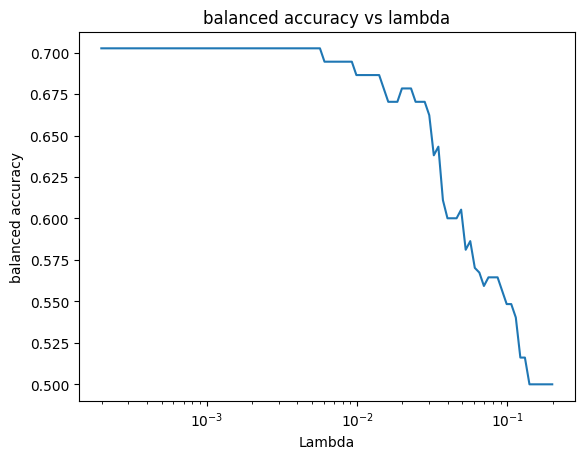

0.005660616012428546
Performance on test set for custom logistic regression:
ROC AUC: 0.7953947368421054
Recall-Precision AUC: 0.7763946996372642
F-score: 0.5957446808510638
Balanced Accuracy: 0.6938596491228071
Coefficient values obtained (custom model):
Coefficients: [-0.01911463 -0.050932    0.02883198  0.00076495  0.07044374 -0.0353177
 -0.00111898  0.06616777 -0.06696579 -0.01461165 -0.01228422 -0.00706583
 -0.03124633  0.00728152 -0.00394041 -0.0385935   0.03364639  0.03771536
  0.03298485  0.          0.01289144  0.         -0.0257014  -0.04393232
  0.          0.00820452  0.00820346 -0.01048655  0.03790564  0.03879467
 -0.03213468  0.01349465  0.02685657 -0.02381429 -0.01456809  0.03298285
 -0.00728538 -0.0234044   0.01155131  0.03283662  0.02671702 -0.02904059
 -0.02461318 -0.01962072  0.02005314 -0.02106555 -0.01461718 -0.02122103
 -0.03516136 -0.00593516  0.01349401  0.00349231  0.05303758  0.01300279
 -0.01788961 -0.02676994  0.01749394  0.          0.037208    0.0093909
  

In [27]:
coef_ccd=evaluate_lr_ccd(X_train, y_train, X_test, y_test, X_valid, y_valid)

In [28]:
coef_ccd=evaluate_lr_ccd(X_train, y_train, X_test, y_test, X_valid, y_valid, user_lambda=0.0056, should_plot=False)

Performance on test set for custom logistic regression:
ROC AUC: 0.7956140350877193
Recall-Precision AUC: 0.7756379065985974
F-score: 0.6105263157894737
Balanced Accuracy: 0.7021929824561404
Coefficient values obtained (custom model):
Coefficients: [-1.30350645e-02 -4.89554843e-02  2.70989792e-02  0.00000000e+00
  7.23278730e-02 -3.18112374e-02 -0.00000000e+00  6.56631108e-02
 -6.32511908e-02 -1.07386337e-02 -6.22044942e-03 -3.51541961e-03
 -2.70758770e-02  4.08318636e-03 -0.00000000e+00 -3.26326180e-02
  2.99798270e-02  3.38335740e-02  2.99009307e-02  0.00000000e+00
  9.20481431e-03  0.00000000e+00 -2.17185401e-02 -3.85546501e-02
  0.00000000e+00  4.44822710e-03  4.44822710e-03 -2.73794118e-03
  3.48027749e-02  3.47624317e-02 -2.40391344e-02  1.05235292e-02
  2.33238798e-02 -1.85886685e-02 -7.15390565e-03  2.99009307e-02
 -7.74995118e-04 -1.93405331e-02  7.23730970e-03  2.79041870e-02
  2.06925835e-02 -2.16054048e-02 -1.72175808e-02 -1.54142737e-02
  1.64764878e-02 -1.65687756e-02 -1.

In [29]:
coef_sk=evaluate_lr_sklearn(X_train, y_train, X_test, y_test)

Performance on test set for sklearn logistic regression:
ROC AUC: 0.6375
Recall-Precision AUC: 0.5520264420265439
F-score: 0.576271186440678
Balanced Accuracy: 0.6254385964912281
Coefficient values obtained (sklearn):
Coefficients: [[-9.09664111e-01 -1.26657775e-01  5.05517669e-01  7.17574297e-01
   5.65633711e+00  6.28512754e-01 -1.15542703e+00  2.38004776e+00
  -3.93916850e+00  3.68026940e+00  2.76003487e-01 -4.93831625e-01
  -5.05431084e+00 -4.77338627e-02 -9.52931576e-01  1.08777204e+00
   3.46145037e-01  3.72993625e+00  1.41105482e+00  0.00000000e+00
   3.75403401e+00  0.00000000e+00 -1.51594572e-01 -3.04777360e-01
   0.00000000e+00  5.35151309e-03  5.35151309e-03 -1.70319461e-01
   4.50869901e+00  2.36922514e+00 -6.38479929e+00  1.37615423e-01
   1.40856979e+00 -1.94794674e-01  3.37897057e-04  1.17587902e-01
  -4.13347070e-02 -2.03666348e-02  9.88371519e-02 -3.01885458e+00
   1.35273868e+00 -8.19773613e+00 -1.64877830e+00 -6.74863365e-01
   3.01840342e+00 -7.23992860e-03 -5.48340

In [30]:
compare_coefficients(coef_ccd, coef_sk, epsilon=0.1)

Average norm of coefficients from model ccd: 0.3854
Average norm of coefficients from model sk: 1.3374
Number of coefficients smaller than 0.1 in model ccd: 0
Number of coefficients smaller than 0.1 in model sk: 81


#### Secom

In [31]:
df_data = pd.read_csv("./data/secom/secom.data", sep=' ', header=None, na_values="NaN")  
df_label = pd.read_csv("./data/secom/secom_labels.data",sep=' ', header=None, na_values="NaN")

df_label.columns = ["label", "timestamp"]
df_secom = pd.concat([df_data, df_label["label"]], axis=1)
print("Shape:", df_secom.shape)
df_secom.columns = df_secom.columns.astype(str)

assign_target_column(df_secom, "label", [1])
fill_na(df_secom)
delete_corr_columns(df_secom)
df_secom = add_permuted_columns(df_secom)
delete_corr_columns(df_secom)
check_feature_sample_ratio(df_secom)
X, y, X_train,X_valid, X_test, y_train, y_valid, y_test = split(df_secom)

Shape: (1567, 591)
Unique values of label column [-1  1]
target
0    1463
1     104
Name: count, dtype: int64
0 6 null values
1 7 null values
2 14 null values
3 14 null values
4 14 null values
5 14 null values
6 14 null values
7 9 null values
8 2 null values
9 2 null values
10 2 null values
11 2 null values
12 2 null values
13 3 null values
14 3 null values
15 3 null values
16 3 null values
17 3 null values
18 3 null values
19 10 null values
21 2 null values
22 2 null values
23 2 null values
24 2 null values
25 2 null values
26 2 null values
27 2 null values
28 2 null values
29 2 null values
30 2 null values
31 2 null values
32 1 null values
33 1 null values
34 1 null values
35 1 null values
36 1 null values
37 1 null values
38 1 null values
39 1 null values
40 24 null values
41 24 null values
42 1 null values
43 1 null values
44 1 null values
45 1 null values
46 1 null values
47 1 null values
48 1 null values
49 1 null values
50 1 null values
51 1 null values
52 1 null values
53 4 nul

0.0502007525439552


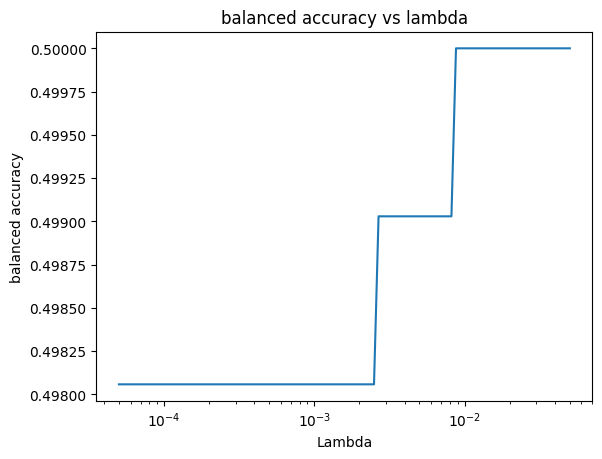

0.0502007525439552
Performance on test set for custom logistic regression:
ROC AUC: 0.6986803519061583
Recall-Precision AUC: 0.12111604429594641
F-score: 0
Balanced Accuracy: 0.5
Coefficient values obtained (custom model):
Coefficients: [-9.53961455e-04  2.93102046e-03  3.18927956e-03  4.77495510e-03
 -4.32932606e-03  0.00000000e+00 -8.45419349e-03  3.68731419e-03
  5.44768661e-03 -7.84955420e-03 -1.66766544e-03 -7.29272542e-03
 -9.31129340e-04  0.00000000e+00 -1.64448612e-03 -1.14396747e-03
 -1.57298684e-03 -1.00540870e-02  8.79372027e-04  9.11023121e-03
 -8.83566709e-03  1.23491829e-02  1.69589980e-03  6.89113974e-03
 -1.07279330e-02 -5.00435122e-03 -1.34473131e-02 -1.37887451e-02
  5.82103921e-03  7.11010004e-03 -8.84809634e-03  1.15349908e-02
  2.30043983e-02  2.70131642e-03  4.15167303e-04  6.52938051e-03
 -1.02100085e-02  2.62215517e-03 -2.68325488e-03 -2.82668887e-03
  0.00000000e+00 -5.19923291e-03  1.79920331e-03 -1.65604592e-03
 -3.90229355e-03  9.74202074e-03  3.98536222e-03

In [33]:
coef_ccd=evaluate_lr_ccd(X_train, y_train, X_test, y_test, X_valid, y_valid)

In [34]:
coef_ccd=evaluate_lr_ccd(X_train, y_train, X_test, y_test, X_valid, y_valid, user_lambda=0.05, should_plot=False)

Performance on test set for custom logistic regression:
ROC AUC: 0.7039956011730205
Recall-Precision AUC: 0.13950123841408213
F-score: 0
Balanced Accuracy: 0.5
Coefficient values obtained (custom model):
Coefficients: [-0.          0.          0.          0.         -0.          0.
 -0.          0.          0.         -0.         -0.         -0.
 -0.          0.         -0.         -0.         -0.         -0.
  0.          0.         -0.          0.         -0.          0.
 -0.         -0.         -0.         -0.          0.          0.
 -0.          0.          0.          0.          0.          0.
 -0.          0.         -0.         -0.          0.         -0.
  0.         -0.         -0.          0.          0.          0.
  0.          0.          0.         -0.          0.         -0.
  0.          0.00020075 -0.         -0.         -0.          0.
  0.          0.         -0.         -0.          0.          0.
  0.          0.         -0.         -0.         -0.         -0.
 -

In [35]:
coef_sk=evaluate_lr_sklearn(X_train, y_train, X_test, y_test)

Performance on test set for sklearn logistic regression:
ROC AUC: 0.5712609970674487
Recall-Precision AUC: 0.08258364676363855
F-score: 0.03571428571428571
Balanced Accuracy: 0.4888563049853372
Coefficient values obtained (sklearn):
Coefficients: [[-3.43881253e-04  3.29664025e-04  1.23581320e-05  2.17229374e-05
  -8.12052198e-04 -5.13981041e-06 -5.83710207e-05  7.26082150e-08
   8.81970611e-07 -4.68802691e-08  6.26025683e-08 -2.02902639e-07
  -1.82769621e-05  0.00000000e+00  3.22384590e-06 -3.87897089e-05
   7.38937650e-06 -1.01874434e-07 -2.56660629e-05  2.67813681e-06
  -5.48411230e-07  4.99967119e-04 -8.93032058e-06  6.59333687e-05
  -1.41735546e-04 -1.03549852e-06 -1.15191499e-06 -1.22284590e-04
   5.59320696e-06  5.33325728e-07 -7.77301073e-07  3.87688477e-05
   4.52902852e-05  6.59831117e-06 -7.00573089e-07 -7.72214951e-07
  -1.10124005e-05 -8.88845418e-06 -2.94423846e-05 -6.02511271e-05
  -3.59786728e-06 -2.98141955e-05 -1.81658304e-07 -1.04121568e-04
  -1.71273345e-04  2.848687

c:\Users\Kuba\.conda\envs\amlenv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [36]:
compare_coefficients(coef_ccd, coef_sk, epsilon=0.1)

Average norm of coefficients from model ccd: 0.0002
Average norm of coefficients from model sk: 0.0001
Number of coefficients smaller than 0.1 in model ccd: 1
Number of coefficients smaller than 0.1 in model sk: 784


#### Braidflow

In [37]:
pd.set_option('display.max_columns', None)

dataset = openml.datasets.get_dataset(45966)

df_braidflow, y, categorical, numeric = dataset.get_data(dataset_format='dataframe', target=dataset.default_target_attribute)

df_braidflow["label"] = y
print("Shape:", df_braidflow.shape)
print(df_braidflow.head(1))
df_braidflow["label"].value_counts()

assign_target_column(df_braidflow, "label", ["flow"])
df_braidflow = drop_categorical(df_braidflow)
fill_na(df_braidflow)
delete_corr_columns(df_braidflow)
check_feature_sample_ratio(df_braidflow)
X, y, X_train,X_valid, X_test, y_train, y_valid, y_test = split(df_braidflow)

Shape: (72, 124)
   UID  task_id  action_absorption  action_accord  action_fluidity  care  \
0    1        5                  3              7                6     3   

   challenge_match  clear_mindedness  control  demand  \
0                4                 5        6       4   

   factor_absorption_by_activity  factor_fluency_of_performance  \
0                            3.5                       6.333333   

   factor_perceived_fit_of_skill_and_task_demands  \
0                                             5.0   

   factor_subjective_value_of_activity  focus  forward_thinking  fss_score  \
0                             2.333333      7                 7        5.2   

   loss_of_time_perception  lost_in_thought  perceived_difficulty  relevance  \
0                        6                1                     4          3   

   self_evaluation  worry task_braid  task_braid_revolutions  \
0                7      1     VBRAID                       6   

   task_braid_strands  bra

0.00365744931014568


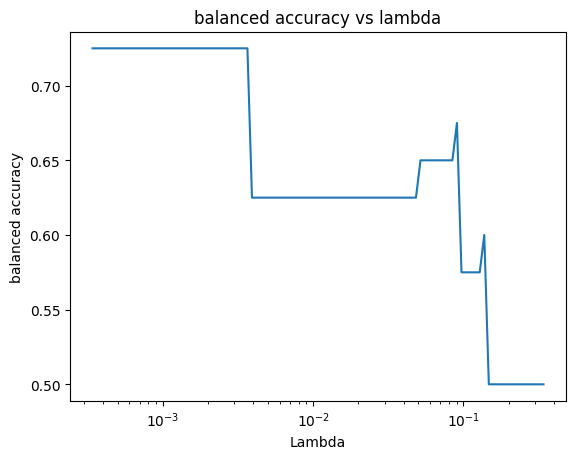

0.00365744931014568
Performance on test set for custom logistic regression:
ROC AUC: 0.7647058823529411
Recall-Precision AUC: 0.4377450980392157
F-score: 0.5
Balanced Accuracy: 0.6705882352941177
Coefficient values obtained (custom model):
Coefficients: [-0.01140446  0.04679941  0.0785753   0.13083033  0.05525857  0.11148334
  0.07882933  0.07995604  0.07676377 -0.03238452  0.13834124  0.10359689
 -0.04212565  0.10761368  0.05344945  0.0729573   0.00883014  0.14116178
 -0.00924784  0.08637329 -0.01047712  0.04834727 -0.03169713 -0.03364246
  0.01451305 -0.         -0.00927139  0.09949356  0.05958609 -0.02071503
  0.01664039  0.04113525  0.09091926  0.05074206 -0.01158803  0.01691136
  0.0413741   0.07346948  0.01834966  0.02254803 -0.00366557  0.00690269
  0.01555809  0.02636967  0.04065515 -0.00104634  0.00961952 -0.03201795
 -0.05015565  0.02086786  0.01143925  0.05190159  0.10780783 -0.00812303
 -0.04117496  0.00338393 -0.007702   -0.04764927 -0.06991506 -0.04457098
 -0.0288414  -0.

In [38]:
coef_ccd=evaluate_lr_ccd(X_train, y_train, X_test, y_test, X_valid, y_valid)

In [40]:
coef_ccd=evaluate_lr_ccd(X_train, y_train, X_test, y_test, X_valid, y_valid, user_lambda=0.0036, should_plot=False)

Performance on test set for custom logistic regression:
ROC AUC: 0.7647058823529411
Recall-Precision AUC: 0.4377450980392157
F-score: 0.5
Balanced Accuracy: 0.6705882352941177
Coefficient values obtained (custom model):
Coefficients: [-0.00892291  0.04373259  0.07691475  0.13087422  0.05259612  0.11113224
  0.07719677  0.0781418   0.07518692 -0.02965676  0.13883145  0.10268125
 -0.03976951  0.10692827  0.05116099  0.07161693  0.00587301  0.14153978
 -0.00515484  0.08482389 -0.00757507  0.04595968 -0.02899221 -0.03144789
  0.01128969  0.         -0.00557124  0.09943861  0.05793686 -0.01815295
  0.01305847  0.03860418  0.09070002  0.04879728 -0.00802302  0.01322531
  0.03984915  0.07232902  0.01548064  0.02041225 -0.          0.00420905
  0.01286314  0.023984    0.03869387 -0.          0.00708495 -0.02997081
 -0.04840046  0.01836934  0.00854445  0.0499647   0.10712774 -0.00415247
 -0.03862882  0.         -0.00333575 -0.04528539 -0.06757503 -0.04295128
 -0.02656256 -0.04271751  0.04682264

In [41]:
coef_sk=evaluate_lr_sklearn(X_train, y_train, X_test, y_test)

Performance on test set for sklearn logistic regression:
ROC AUC: 0.2235294117647059
Recall-Precision AUC: 0.1741441564970977
F-score: 0.0
Balanced Accuracy: 0.5
Coefficient values obtained (sklearn):
Coefficients: [[-1.90915419e-07  2.42326069e-08  1.31272507e-07  1.58335162e-07
   8.53082755e-08  2.35694782e-07  1.13892536e-07  1.05349201e-07
   1.28250330e-07 -2.29948918e-08  1.26261998e-07  1.11654950e-07
  -1.36389302e-08  1.42129089e-07  8.49259927e-08  1.07760738e-07
   2.48523582e-08  2.35030593e-07 -1.21228387e-08  1.41734645e-07
  -5.79906009e-09  4.89578401e-08 -4.83986075e-08 -4.33729543e-06
   4.66166752e-10  4.61297679e-11  1.40466587e-09  1.17826519e-11
   7.84572374e-12 -2.26829820e-10 -1.36108370e-11  1.80504986e-10
   5.43065458e-09  3.64766949e-09  7.25695067e-11 -1.93993650e-10
   1.07446997e-07  8.85207407e-07  7.27727371e-11  1.77016544e-10
   1.60934206e-10  1.97798058e-10  3.06108727e-10  6.85167103e-11
   1.41011432e-10 -4.06142998e-10  5.70524716e-08 -1.564359

In [42]:
compare_coefficients(coef_ccd, coef_sk, epsilon=0.1)

Average norm of coefficients from model ccd: 0.4675
Average norm of coefficients from model sk: 0.0000
Number of coefficients smaller than 0.1 in model ccd: 0
Number of coefficients smaller than 0.1 in model sk: 78


#### LSVT

In [43]:
dataset = openml.datasets.get_dataset(1484)
df_lsvt, y, categorical, numeric = dataset.get_data(dataset_format='dataframe', target=dataset.default_target_attribute)

df_lsvt["label"] = y
print("Shape:", df_lsvt.shape)
print(df_lsvt.head(1))
df_lsvt["label"].value_counts()

assign_target_column(df_lsvt, "label", ['1'])
fill_na(df_lsvt)
delete_corr_columns(df_lsvt)
check_feature_sample_ratio(df_lsvt)
X, y, X_train,X_valid, X_test, y_train, y_valid, y_test = split(df_lsvt)

Shape: (126, 311)
         V1        V2       V3        V4        V5        V6        V7  \
0  0.088112  0.041697  0.00048 -0.000004  0.000422  2.458381  0.000001   

          V8          V9       V10       V11       V12       V13       V14  \
0  47.021079  1366.43039 -7.103323 -2.687924 -0.035674  2.849068  0.042287   

        V15       V16      V17       V18       V19      V20       V21  \
0  9.116401  0.000002  0.04192  0.000482  0.000004  0.00044  0.000055   

        V22  V23       V24  V25  V26  V27  V28       V29       V30       V31  \
0  0.000001  0.0  0.000001  0.0    0    0    0  0.042287  0.000204  0.069838   

         V32      V33       V34      V35      V36       V37      V38  \
0  11.566415  0.07716 -0.000064  0.08188  0.09207 -0.000057  0.08188   

        V39       V40      V41       V42       V43       V44       V45  \
0  0.100744  0.000057  0.08188  0.059512  1.012151  0.021821  0.076036   

        V46      V47       V48       V49       V50       V51        V52  \

0.14179704897644588


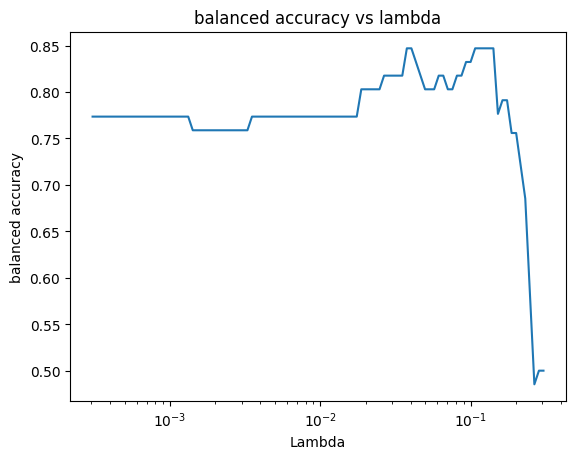

0.14179704897644588
Performance on test set for custom logistic regression:
ROC AUC: 0.9647435897435898
Recall-Precision AUC: 0.8455342111592112
F-score: 0.6666666666666666
Balanced Accuracy: 0.7692307692307692
Coefficient values obtained (custom model):
Coefficients: [-0.0528057   0.07477953 -0.03085825 -0.0082268   0.03244486  0.0423196
  0.01083512 -0.07591577 -0.00214929  0.00678591  0.          0.
  0.          0.         -0.0276068  -0.00958839 -0.04133015 -0.02965475
 -0.05786827 -0.04958952 -0.05266743  0.05527747 -0.09957473 -0.01797884
  0.03518058 -0.01652731 -0.05838765 -0.06863576  0.08375943  0.00781156
  0.00292989  0.02524005 -0.03362781 -0.02091519  0.01885608  0.02445706
 -0.          0.01830682  0.04584865  0.02595172  0.05817358  0.06836653
  0.02571907 -0.10932132 -0.12652029  0.11700082  0.08276466  0.07940664
  0.03235875 -0.04228351  0.04264868  0.04702023  0.06769757 -0.03724202
 -0.02444512  0.00997535  0.02446198 -0.02558222  0.02609511 -0.04820166
  0.064818

In [44]:
coef_ccd=evaluate_lr_ccd(X_train, y_train, X_test, y_test, X_valid, y_valid)

In [45]:
coef_ccd=evaluate_lr_ccd(X_train, y_train, X_test, y_test, X_valid, y_valid, user_lambda=0.14, should_plot=False)

Performance on test set for custom logistic regression:
ROC AUC: 0.8782051282051282
Recall-Precision AUC: 0.680072528234293
F-score: 0.7142857142857143
Balanced Accuracy: 0.8012820512820513
Coefficient values obtained (custom model):
Coefficients: [-0.02138178  0.         -0.         -0.          0.          0.
  0.         -0.         -0.         -0.          0.          0.
  0.          0.         -0.          0.         -0.         -0.
 -0.00322916 -0.         -0.0082133   0.00050632 -0.04513794 -0.
  0.         -0.         -0.01178964 -0.01335383  0.          0.
 -0.          0.         -0.         -0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.02257189 -0.07914563  0.07677089  0.01916134  0.00997296
  0.         -0.          0.          0.          0.         -0.
 -0.         -0.          0.         -0.          0.         -0.
  0.          0.         -0.         -0.         -0.03883902  0.
 -0.         -0.         -0. 

In [183]:
coef_sk=evaluate_lr_sklearn(X_train, y_train, X_test, y_test)

Performance on test set for sklearn logistic regression:
ROC AUC: 0.6602564102564101
Recall-Precision AUC: 0.48659929082697956
F-score: 0.5142857142857142
Balanced Accuracy: 0.6057692307692308
Coefficient values obtained (sklearn):
Coefficients: [[-1.74083236e-07  2.80504690e-12 -3.66613099e-06 -2.32209217e-05
  -3.51555368e-05  6.88116374e-06  4.61373592e-07 -2.24527843e-12
  -3.70010701e-14 -1.02019598e-13  1.64972734e-14  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -6.12874460e-09  4.10401827e-11
  -5.79295434e-11 -1.23836147e-10 -9.97684335e-09 -1.63994884e-09
  -6.92748103e-08  2.66377659e-06 -5.39580743e-07 -1.17285077e-07
   1.21543543e-08 -7.19574213e-06 -2.17220515e-06 -6.24121645e-08
   1.96439965e-08  3.95192174e-08 -4.96229388e-09 -7.09522642e-07
  -2.41683613e-08 -1.92739673e-08  1.64034283e-09  5.67873206e-10
   1.46163585e-05  3.08951141e-08  9.96941163e-08  2.13649643e-07
   6.16296917e-08  1.21874973e-08  7.60951428e-07 -6.41681923e-07
  -2.59329770e-06  8.1462271

c:\Users\Kuba\.conda\envs\amlenv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [184]:
compare_coefficients(coef_ccd, coef_sk, epsilon=0.1)

Average norm of coefficients from model ccd: 0.5022
Average norm of coefficients from model sk: 0.0000
Number of coefficients smaller than 0.1 in model ccd: 0
Number of coefficients smaller than 0.1 in model sk: 106
